In [ ]:
!pip install pyts

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
!pip install wfdb

In [1]:
from pyts.image import GramianAngularField, MarkovTransitionField
import matplotlib.pyplot as plt
import pandas as pd
import os
import wfdb
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [2]:
path_ = '/content/drive/My Drive/DSL/test/'

df = pd.read_csv(os.path.join(path_,'ptbxl_database.csv'))

for f in df.filename_lr:
    print(f)
    print(path_+f)
    x_example = wfdb.rdsamp(path_+f)
    break

records100/00000/00001_lr
/content/drive/My Drive/DSL/test/records100/00000/00001_lr


In [3]:
x_example[0][:,0].shape

(1000,)

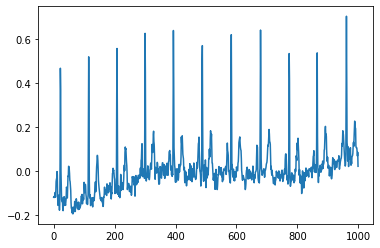

In [4]:
import matplotlib.pyplot as plt
plt.plot(x_example[0][:,0])

<font color=#c33432, size=6>1D ECG Signal</font>

In [5]:
x_example_lead1 = x_example[0][:,1]
x_example_lead1 = x_example_lead1[:100]
x_example_lead1.shape

#normalization
x_example_lead1 = (x_example_lead1 -min(x_example_lead1)) / max(x_example_lead1-min(x_example_lead1))

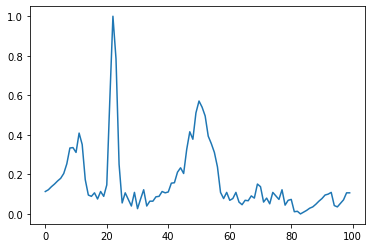

In [6]:
plt.plot(x_example_lead1)

The following functions are based on a publicly available implementation for ECG to image conversion (https://github.com/zaamad/ECG-Heartbeat-Classification-Using-Multimodal-Fusion/blob/main/heartbeat_data_generator-MITBIH.ipynb)

<font color=#c33432, size=6>Gramian Angular Field</font>



In [7]:
# Gramian Angular Field
gaf = GramianAngularField(image_size=100, method='summation')

In [8]:
x_gaf = gaf.fit_transform(x_example_lead1.reshape(1,-1))

In [9]:
x_gaf.shape

(1, 100, 100)

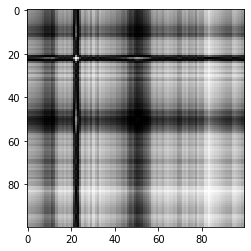

In [10]:
plt.imshow(x_gaf[0], cmap='gray')

<font color=#c33432, size=6>Markov Transition Field</font>

In [11]:
# Hearbeat values range from 0 to 1; we will divide into quantiles and see which bin each value belongs to
# and what the probability is to transfer from 1 bin to other
# i.e if 1 value is in bin 1 and the next value is in bin 5, what is the probability of transferring from
# bin 1 to 5
# correlation matrix of probabilities is markov transition field
def get_quantiles(min_value=0, max_val=1, k=10):
    c = (max_val - min_value)/k
    b = min_value + c
    d = []
    for i in range(1, k):
        d.append(b)
        b += c
    d.append(max_val)
    return d

quantiles = get_quantiles()

def value_to_quantile(x):
    for i, k in enumerate(quantiles):
        if x <= k:
            return i
    return 0

def get_mtf(x, size=10):
    q = np.vectorize(value_to_quantile)(x)
    r = np.zeros((q.shape[0], q.shape[0]))
    y = np.zeros((size, size))
    for i in range(x.shape[0] - 1):
        y[q[i], q[i + 1]] += 1
    y = y / y.sum(axis=1, keepdims=True)
    y[np.isnan(y)] = 0
    
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            r[i, j] = y[q[i], q[j]]
    return r / 5. - 1

In [12]:
mtf = get_mtf(x_example_lead1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


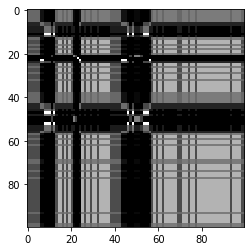

In [13]:
plt.imshow(mtf, cmap='gray')

<font color=#c33432, size=6>Recurrence Plot</font>

In [14]:
# recurrence plot
def recurrence_plot(s, eps=None, steps=None):
    result = []
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = pairwise_distances(s[:, None])
    d = d / eps
    d[d > steps] = steps
    return d/5. - 1

In [15]:
rp = recurrence_plot(x_example_lead1, steps=10)

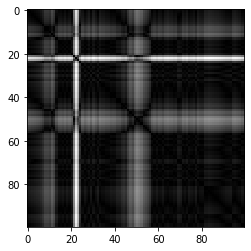

In [16]:
plt.imshow(rp, cmap='gray')

**One Heartbeat**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Recurrence Plot')

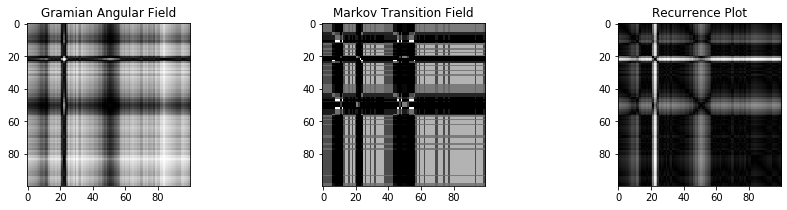

In [17]:
x_example_lead2 = x_example[0][:,1]
x_example_lead2 = x_example_lead2[:100]
x_example_lead2.shape

x_example_lead2 = (x_example_lead2 -min(x_example_lead2)) / max(x_example_lead2-min(x_example_lead2))

x_gaf = gaf.fit_transform(x_example_lead2.reshape(1,-1))
mtf = get_mtf(x_example_lead2)
rp = recurrence_plot(x_example_lead2, steps=10)

plt.rcParams["figure.figsize"] = (15,3)

f, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(x_gaf[0], cmap='gray')
ax1.set_title('Gramian Angular Field')
ax2.imshow(mtf, cmap='gray')
ax2.set_title('Markov Transition Field')
ax3.imshow(rp, cmap='gray')
ax3.set_title('Recurrence Plot')

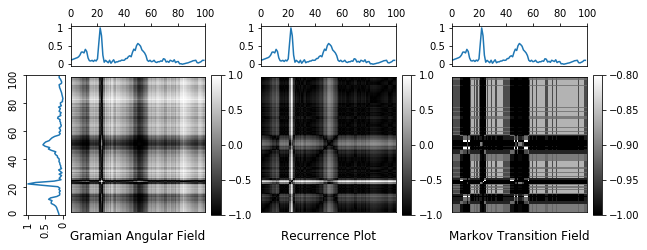

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

#plot based on https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html#sphx-glr-auto-examples-image-plot-single-gaf-py

# ECG signal (first 100 points)
x = x_example_lead1
X = x.reshape(1,-1)
time_points = np.arange(0,100)

# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)


# Plot the time series and its recurrence plot
width_ratios = (2, 7, 0.5, 1.5, 7, 0.5, 1.5, 7, 0.5)
height_ratios = (2, 7)
width = 10
height = width * sum(height_ratios) / sum(width_ratios)
fig = plt.figure(figsize=(width, height))
gs = fig.add_gridspec(2, 9,  width_ratios=width_ratios,
                      height_ratios=height_ratios,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 100, 6)
time_ticklabels = [r'$0$', r'$20$', r'$40$', 
                   r'$60$', r'$80$', r'$100$']
value_ticks = [0, 0.5, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.set_ylim((0, 100))
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top1 = fig.add_subplot(gs[0, 1])
ax_top1.plot(time_points, x)
ax_top1.set_xticks(time_ticks)
ax_top1.set_xticklabels(time_ticklabels)
ax_top1.set_yticks(value_ticks)
ax_top1.xaxis.tick_top()
ax_top1.set_xlim((0, 100))
ax_top1.set_yticklabels(value_ticks)


# Plot the Gramian angular fields on the bottom right
ax_gasf = fig.add_subplot(gs[1, 1])
im = ax_gasf.imshow(X_gasf[0], cmap='gray', origin = 'lower',
               extent=[0,100, 0,100])
ax_gasf.set_xticks([])
ax_gasf.set_yticks([])
ax_gasf.set_title('Gramian Angular Field', y=-0.25)


# Add colorbar
ax_cbar = fig.add_subplot(gs[1, 2])
fig.colorbar(im, cax=ax_cbar)


# Plot the time series on the top
ax_top2 = fig.add_subplot(gs[0, 4])
ax_top2.plot(time_points, x)
ax_top2.set_xticks(time_ticks)
ax_top2.set_xticklabels(time_ticklabels)
ax_top2.set_yticks(value_ticks)
ax_top2.xaxis.tick_top()
ax_top2.set_xlim((0, 100))
ax_top2.set_yticklabels(value_ticks)


# Plot the Recurrence plot on the bottom middle
ax_gasf = fig.add_subplot(gs[1, 4])
im = ax_gasf.imshow(rp, cmap='gray', origin = 'lower',
               extent=[0,100, 0,100])
ax_gasf.set_xticks([])
ax_gasf.set_yticks([])
ax_gasf.set_title('Recurrence Plot', y=-0.25)


# Add colorbar
ax_cbar = fig.add_subplot(gs[1, 5])
fig.colorbar(im, cax=ax_cbar)


# Plot the time series on the top
ax_top3 = fig.add_subplot(gs[0, 7])
ax_top3.plot(time_points, x)
ax_top3.set_xticks(time_ticks)
ax_top3.set_xticklabels(time_ticklabels)
ax_top3.set_yticks(value_ticks)
ax_top3.xaxis.tick_top()
ax_top3.set_xlim((0, 100))
ax_top3.set_yticklabels(value_ticks)


# Plot the Recurrence plot on the bottom middle
ax_gasf = fig.add_subplot(gs[1, 7])
im = ax_gasf.imshow(mtf, cmap='gray', origin = 'lower',
               extent=[0,100, 0,100])
ax_gasf.set_xticks([])
ax_gasf.set_yticks([])
ax_gasf.set_title('Markov Transition Field', y=-0.25)


# Add colorbar
ax_cbar = fig.add_subplot(gs[1, 8])
fig.colorbar(im, cax=ax_cbar)


plt.show()

**Entire Signal**

Text(0.5, 1.0, 'Recurrence Plot')

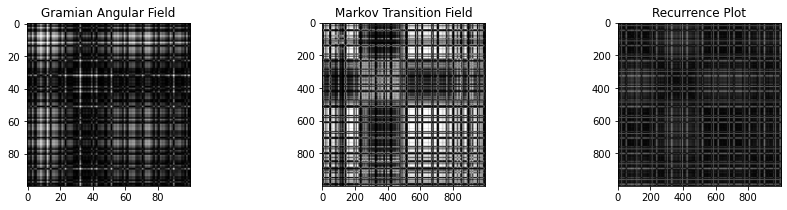

In [ ]:
x_example_lead2 = x_example[0][:,1]
x_example_lead2.shape

x_example_lead2 = (x_example_lead2 -min(x_example_lead2)) / max(x_example_lead2-min(x_example_lead2))

x_gaf = gaf.fit_transform(x_example_lead2.reshape(1,-1))
mtf = get_mtf(x_example_lead2)
rp = recurrence_plot(x_example_lead2, steps=10)

plt.rcParams["figure.figsize"] = (15,3)

f, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(x_gaf[0], cmap='gray')
ax1.set_title('Gramian Angular Field')
ax2.imshow(mtf, cmap='gray')
ax2.set_title('Markov Transition Field')
ax3.imshow(rp, cmap='gray')
ax3.set_title('Recurrence Plot')